In [2]:
print("Hello, Colab!")

Hello, Colab!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np

# For splitting data and scaling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

# For balancing data classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Logistic Regression model and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.feature_selection import RFE



## ***Adding Sentiment Score as a feature***

In [4]:
# Load the dataset
file_path = '/content/drive/My Drive/nlp/dataset_final/daily_news/mrk/MRK_text_annotated.csv'
file_path_num = '/content/drive/My Drive/nlp/dataset_final/daily_news/mrk/MRK_numerical_LR.csv'

data = pd.read_csv(file_path_num)
data_sent = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data_sent.head())

   Unnamed: 0                                              title stock  \
0      838963  Shares of several healthcare companies are tra...   MRK   
1      838964  Johnson & Johnson To Start Coronavirus Vaccine...   MRK   
2      838965  The Daily Biotech Pulse: Keytruda Setback For ...   MRK   
3      838966  Merck Announces That The Phase 3 KEYNOTE-361 T...   MRK   
4      838967  The Week Ahead In Biotech: Viela FDA Decision,...   MRK   

         Date  sentiment_score  
0  2020-06-11            -0.31  
1  2020-06-11             0.01  
2  2020-06-10            -0.38  
3  2020-06-09             0.00  
4  2020-06-07             0.01  


In [5]:
# Check if 'Unnamed: 0' exists in the columns and drop it
if 'Unnamed: 0' in data_sent.columns:
    data_sent = data_sent.drop(columns=['Unnamed: 0'])
data_sent.rename(columns={'Time': 'Date'}, inplace=True)
data_sent.head()

,title,stock,Date,sentiment_score
0,Shares of several healthcare companies are tra...,MRK,2020-06-11,-0.31
1,Johnson & Johnson To Start Coronavirus Vaccine...,MRK,2020-06-11,0.01
2,The Daily Biotech Pulse: Keytruda Setback For ...,MRK,2020-06-10,-0.38
3,Merck Announces That The Phase 3 KEYNOTE-361 T...,MRK,2020-06-09,0.00
4,"The Week Ahead In Biotech: Viela FDA Decision,...",MRK,2020-06-07,0.01


In [6]:
# Ensure the Date columns are in datetime format in both DataFrames
data_sent['Date'] = pd.to_datetime(data_sent['Date'])
data['Date'] = pd.to_datetime(data['Date'])


# Calculate the aggregate sentiment score for each date in sentiment_data
aggregate_sentiment = data_sent.groupby('Date', as_index=False)['sentiment_score'].sum()
aggregate_sentiment.rename(columns={'sentiment_score': 'aggregate_sentiment_score'}, inplace=True)

# Merge the stock data (data) with the aggregated sentiment data
merged_data = pd.merge(data, aggregate_sentiment, on='Date', how='inner')

# Select the required columns
final_data = merged_data[['Date', 'Open', 'Close', 'High', 'Volume', 'aggregate_sentiment_score']]

# Inspect the final DataFrame
final_data.head()


,Date,Open,Close,High,Volume,aggregate_sentiment_score
0,2020-06-01,64.97,64.46,65.19,6269241.0,0.23
1,2020-05-29,64.38,65.40,65.58,13517104.0,0.03
2,2020-05-28,63.69,64.04,65.06,13180906.0,-0.01
3,2020-05-26,63.41,62.60,63.69,19146017.0,-0.59
4,2020-05-22,61.72,61.88,62.11,6357482.0,0.27


In [7]:
# Calculate next-day return
final_data['Movement'] = ((final_data['Open'].shift(-1) - final_data['Close']) / data['Close'])

# Shift Movement to align with current day
final_data['Movement'] = final_data['Movement'].shift(1)

# Drop the last row because there's no next day to compare
final_data = final_data.dropna(subset=['Movement'])

# Convert Movement into binary (1 for up if Movement > 0, else 0)
final_data['Movement'] = (final_data['Movement'] > 0).astype(int)

# Calculate daily returns (in percentage)
final_data['Daily_Return'] = final_data['Close'].pct_change() * 100

# Choose a rolling window (e.g., 10 days) for volatility
window_size = 5
final_data['Volatility'] = final_data['Daily_Return'].rolling(window=window_size).std()

# Drop the initial NaNs from rolling calculation
final_data = final_data.dropna(subset=['Volatility'])

# Define a rolling window size for sentiment volatility
sentiment_window_size = 5  # You can adjust the window size as needed

# Calculate rolling standard deviation of the aggregate sentiment score
final_data['sentiment_volatility'] = final_data['aggregate_sentiment_score'].rolling(window=sentiment_window_size).std()

# Create lagged sentiment volatility to avoid data leakage
final_data['sentiment_volatility_lag1'] = final_data['sentiment_volatility'].shift(1)

# Create lagged sentiment volatility to avoid data leakage
final_data['aggregate_sentiment_score_lag1'] = final_data['aggregate_sentiment_score'].shift(1)

# Drop rows with NaN values introduced by rolling and shifting
final_data = final_data.dropna(subset=['sentiment_volatility_lag1', 'aggregate_sentiment_score_lag1'])

# Create lagged features to avoid data leakage
final_data['Close_lag1'] = final_data['Close'].shift(1)
final_data['High_lag1'] = final_data['High'].shift(1)
final_data['Volume_lag1'] = final_data['Volume'].shift(1)
final_data['Daily_Return_lag1'] = final_data['Daily_Return'].shift(1)
final_data['Volatility_lag1'] = final_data['Volatility'].shift(1)

# Drop rows with NaN values introduced by shifting
final_data = final_data.dropna(subset=['Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1', 'sentiment_volatility_lag1'])


final_data.head(10)

/tmp/ipython-input-3626410606.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Movement'] = ((final_data['Open'].shift(-1) - final_data['Close']) / data['Close'])
/tmp/ipython-input-3626410606.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Movement'] = final_data['Movement'].shift(1)


,Date,Open,Close,High,Volume,aggregate_sentiment_score,Movement,Daily_Return,Volatility,sentiment_volatility,sentiment_volatility_lag1,aggregate_sentiment_score_lag1,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1
12,2020-05-05,62.59,63.21,63.85,7401395.0,0.00,1,1.152184,1.239080,0.146048,0.138311,0.00,62.49,63.72,12414922.0,0.953150,1.185258
13,2020-04-30,64.68,64.29,65.15,11638878.0,0.05,1,1.708590,1.434617,0.032094,0.146048,0.00,63.21,63.85,7401395.0,1.152184,1.239080
14,2020-04-29,66.60,65.45,66.60,13687194.0,0.03,1,1.804324,1.542189,0.021679,0.032094,0.05,64.29,65.15,11638878.0,1.708590,1.434617
15,2020-04-28,65.78,65.78,66.63,20273560.0,-0.19,1,0.504202,0.540423,0.096281,0.021679,0.03,65.45,66.60,13687194.0,1.804324,1.542189
16,2020-04-27,65.82,68.05,68.61,12786753.0,0.45,1,3.450897,1.095872,0.233923,0.096281,-0.19,65.78,66.63,20273560.0,0.504202,0.540423
17,2020-04-24,66.12,65.98,66.52,7686451.0,0.29,0,-3.041881,2.432729,0.248355,0.233923,0.45,68.05,68.61,12786753.0,3.450897,1.095872
18,2020-04-23,64.98,65.53,66.34,8152497.0,0.46,0,-0.682025,2.465159,0.282347,0.248355,0.29,65.98,66.52,7686451.0,-3.041881,2.432729
19,2020-04-21,66.13,63.65,66.69,17876574.0,-0.54,1,-2.868915,2.679565,0.442075,0.282347,0.46,65.53,66.34,8152497.0,-0.682025,2.465159
20,2020-04-20,67.11,67.33,68.17,11675768.0,0.01,1,5.781618,3.933544,0.418366,0.442075,-0.54,63.65,66.69,17876574.0,-2.868915,2.679565
21,2020-04-16,66.97,67.25,67.52,9145058.0,0.47,0,-0.118818,3.578307,0.422220,0.418366,0.01,67.33,68.17,11675768.0,5.781618,3.933544


In [8]:
final_data.to_csv('/content/drive/My Drive/nlp/dataset_final/daily_news/mrk/merged_MRK.csv')

In [9]:
final_data.columns

Index(['Date', 'Open', 'Close', 'High', 'Volume', 'aggregate_sentiment_score',
       'Movement', 'Daily_Return', 'Volatility', 'sentiment_volatility',
       'sentiment_volatility_lag1', 'aggregate_sentiment_score_lag1',
       'Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1',
       'Volatility_lag1'],
      dtype='object')

In [11]:
# Correlation Metrics
# Specify the columns of interest for correlation with 'Movement'
columns_of_interest = ['aggregate_sentiment_score', 'sentiment_volatility', 'sentiment_volatility_lag1', 'aggregate_sentiment_score_lag1']

# Calculate the correlation between 'Movement' and each of the specified columns
correlation_with_movement = final_data[columns_of_interest + ['Movement']].corr()['Movement']

# Drop the self-correlation of 'Movement'
correlation_with_movement = correlation_with_movement.drop('Movement')

# Display the correlation values
print(correlation_with_movement)


aggregate_sentiment_score        -0.015578
sentiment_volatility              0.022207
sentiment_volatility_lag1        -0.005224
aggregate_sentiment_score_lag1   -0.131132
Name: Movement, dtype: float64


In [12]:
# Define features (X) and target (y)
features = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1', 'aggregate_sentiment_score_lag1', 'sentiment_volatility_lag1']
X = final_data[features]
y = final_data['Movement']


In [13]:
# Ensure the 'Date' column is in datetime format
final_data['Date'] = pd.to_datetime(final_data['Date'])  # Ensure correct datetime format
final_data.set_index('Date', inplace=True)
print(final_data.index)


DatetimeIndex(['2020-05-05', '2020-04-30', '2020-04-29', '2020-04-28',
               '2020-04-27', '2020-04-24', '2020-04-23', '2020-04-21',
               '2020-04-20', '2020-04-16',
               ...
               '2009-11-16', '2009-11-13', '2009-11-09', '2009-11-06',
               '2009-11-04', '2009-09-18', '2009-08-17', '2009-08-10',
               '2009-08-07', '2009-07-27'],
              dtype='datetime64[ns]', name='Date', length=1431, freq=None)


In [14]:
X.index = final_data.index
print(X.index)

DatetimeIndex(['2020-05-05', '2020-04-30', '2020-04-29', '2020-04-28',
               '2020-04-27', '2020-04-24', '2020-04-23', '2020-04-21',
               '2020-04-20', '2020-04-16',
               ...
               '2009-11-16', '2009-11-13', '2009-11-09', '2009-11-06',
               '2009-11-04', '2009-09-18', '2009-08-17', '2009-08-10',
               '2009-08-07', '2009-07-27'],
              dtype='datetime64[ns]', name='Date', length=1431, freq=None)


In [15]:
# Initialize lists to store train and test years
# Initialize TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)
train_years = []
test_years = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Map the integer indices back to the DatetimeIndex
    train_dates = X.index[train_index]
    test_dates = X.index[test_index]

    # Store the dates
    train_years.append(train_dates)
    test_years.append(test_dates)

    # Print the date range for each fold (optional)
    print(f"Fold {fold + 1}:")
    print(f"Train Dates: {train_dates.min().strftime('%Y-%m-%d')} to {train_dates.max().strftime('%Y-%m-%d')}")
    print(f"Test Dates: {test_dates.min().strftime('%Y-%m-%d')} to {test_dates.max().strftime('%Y-%m-%d')}")
    print("-" * 50)


Fold 1:
Train Dates: 2018-11-30 to 2020-05-05
Test Dates: 2017-05-26 to 2018-11-29
--------------------------------------------------
Fold 2:
Train Dates: 2017-05-26 to 2020-05-05
Test Dates: 2015-08-18 to 2017-05-25
--------------------------------------------------
Fold 3:
Train Dates: 2015-08-18 to 2020-05-05
Test Dates: 2013-10-02 to 2015-08-13
--------------------------------------------------
Fold 4:
Train Dates: 2013-10-02 to 2020-05-05
Test Dates: 2011-09-08 to 2013-10-01
--------------------------------------------------
Fold 5:
Train Dates: 2011-09-08 to 2020-05-05
Test Dates: 2009-07-27 to 2011-09-07
--------------------------------------------------


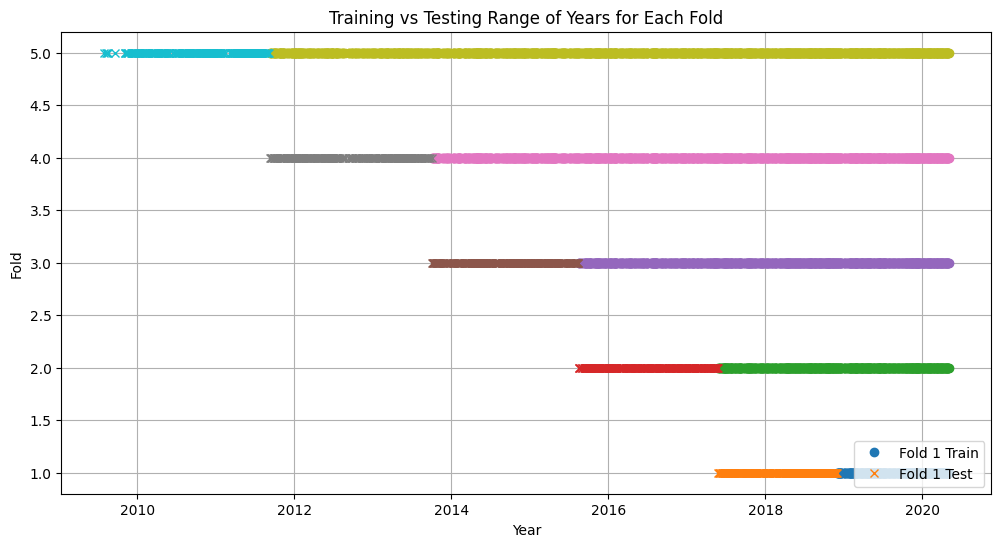

In [16]:
# Plot training vs testing years
plt.figure(figsize=(12, 6))

for i, (train, test) in enumerate(zip(train_years, test_years)):
    plt.plot(train, [i + 1] * len(train), 'o', label=f'Fold {i + 1} Train' if i == 0 else "")
    plt.plot(test, [i + 1] * len(test), 'x', label=f'Fold {i + 1} Test' if i == 0 else "")

plt.xlabel('Year')
plt.ylabel('Fold')
plt.title('Training vs Testing Range of Years for Each Fold')
plt.legend(loc='lower right')
plt.grid()
plt.show()



Fold 1 Confusion Matrix:
[[114   0]
 [ 68  56]]


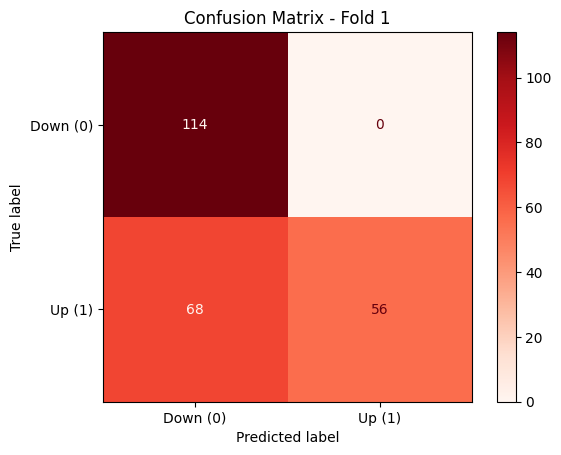

Fold 1 Accuracy: 0.71
--------------------------------------------------

Fold 2 Confusion Matrix:
[[ 57  68]
 [  5 108]]


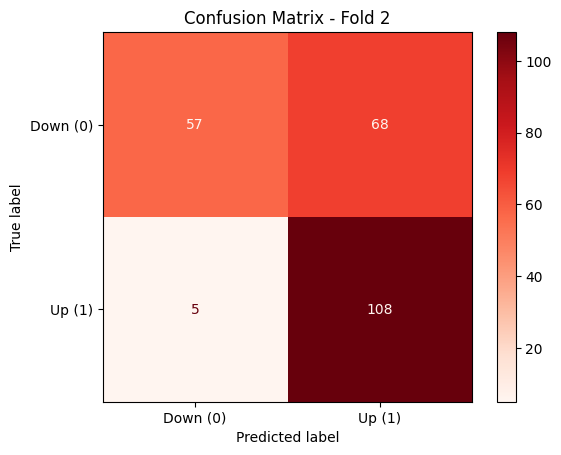

Fold 2 Accuracy: 0.69
--------------------------------------------------

Fold 3 Confusion Matrix:
[[106  17]
 [ 15 100]]


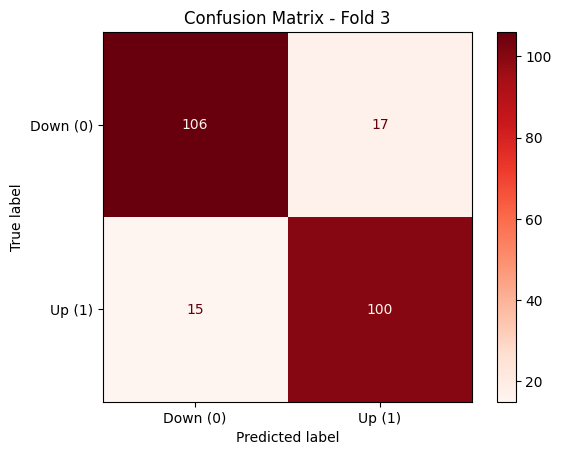

Fold 3 Accuracy: 0.87
--------------------------------------------------

Fold 4 Confusion Matrix:
[[110  33]
 [  3  92]]


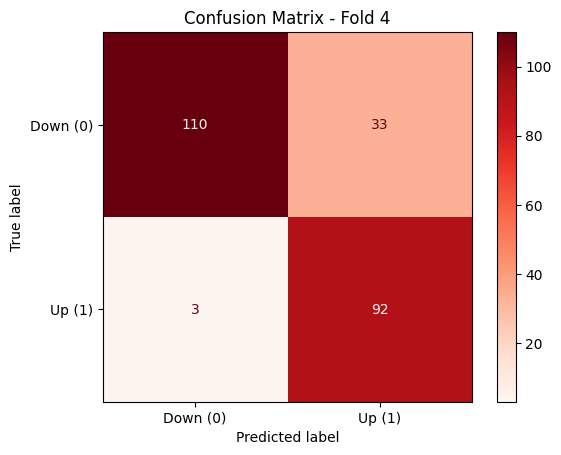

Fold 4 Accuracy: 0.85
--------------------------------------------------

Fold 5 Confusion Matrix:
[[131   6]
 [ 47  54]]


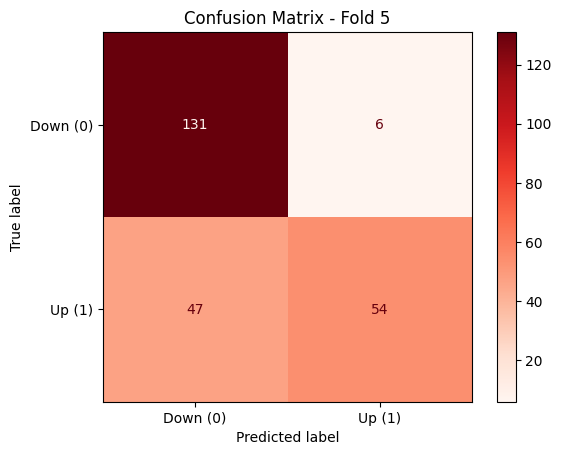

Fold 5 Accuracy: 0.78
--------------------------------------------------

Average Metrics Across Folds:
Accuracy: 0.78
Precision: 0.82
Recall: 0.76
F1-Score: 0.75
ROC-AUC: 0.91

Cross-Validation Accuracy: 0.7798 ± 0.0691


In [17]:
# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Reds")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)

# Print average metrics
print("\nAverage Metrics Across Folds:")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")

mean_acc = np.mean(accuracy_scores)
std_acc = np.std(accuracy_scores)
print(f"\nCross-Validation Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


Fold 1 - Balanced Class Distribution:
Movement
0    112
1    112
Name: count, dtype: int64
--------------------------------------------------

Fold 1 Confusion Matrix:
[[109   5]
 [ 39  85]]


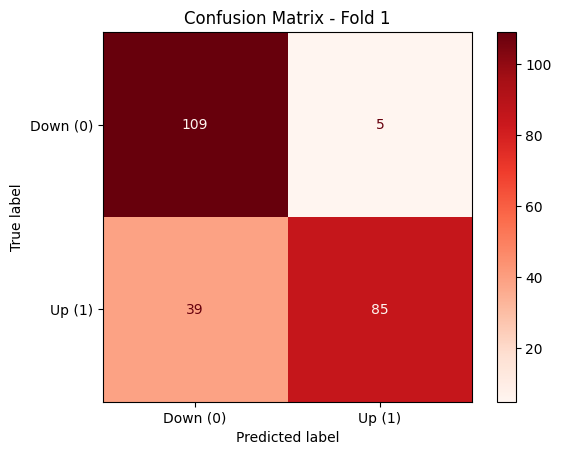

Fold 1 Accuracy: 0.82
--------------------------------------------------
Fold 2 - Balanced Class Distribution:
Movement
0    236
1    236
Name: count, dtype: int64
--------------------------------------------------

Fold 2 Confusion Matrix:
[[ 56  69]
 [  4 109]]


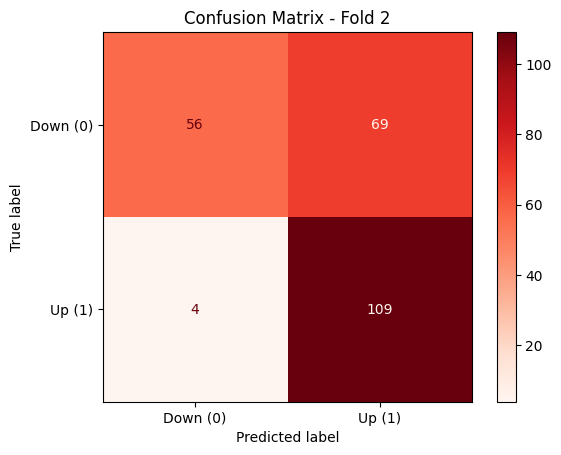

Fold 2 Accuracy: 0.69
--------------------------------------------------
Fold 3 - Balanced Class Distribution:
Movement
0    349
1    349
Name: count, dtype: int64
--------------------------------------------------

Fold 3 Confusion Matrix:
[[ 98  25]
 [ 13 102]]


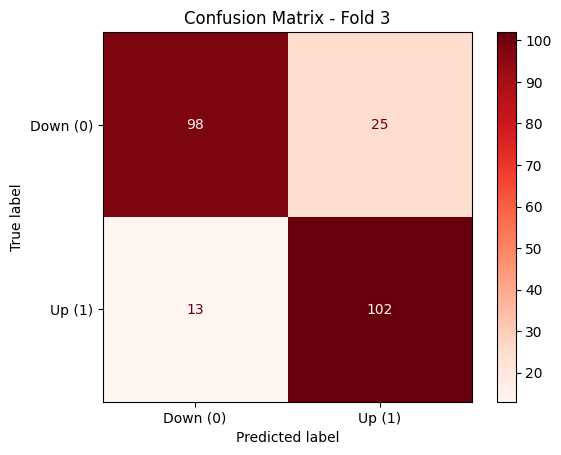

Fold 3 Accuracy: 0.84
--------------------------------------------------
Fold 4 - Balanced Class Distribution:
Movement
0    464
1    464
Name: count, dtype: int64
--------------------------------------------------

Fold 4 Confusion Matrix:
[[100  43]
 [  2  93]]


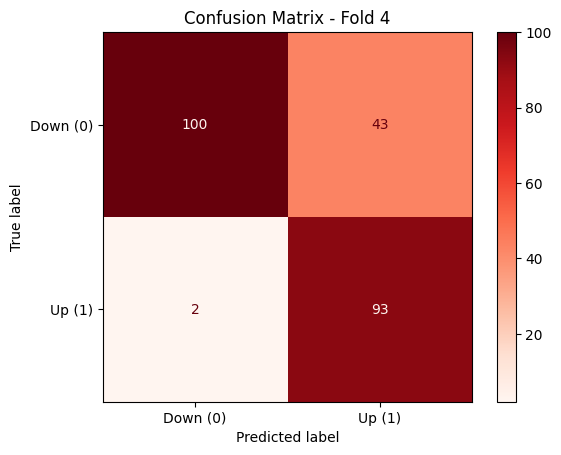

Fold 4 Accuracy: 0.81
--------------------------------------------------
Fold 5 - Balanced Class Distribution:
Movement
0    559
1    559
Name: count, dtype: int64
--------------------------------------------------

Fold 5 Confusion Matrix:
[[121  16]
 [ 29  72]]


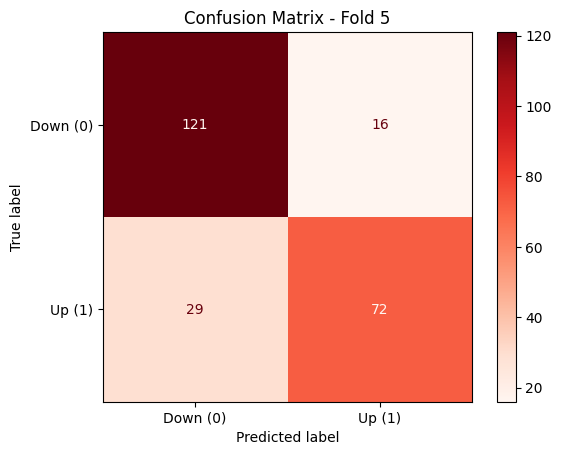

Fold 5 Accuracy: 0.81
--------------------------------------------------

Average Metrics Across Folds (Balanced Data):
Accuracy: 0.79
Precision: 0.77
Recall: 0.85
F1-Score: 0.79
ROC-AUC: 0.91

Cross-Validation Accuracy: 0.7941 ± 0.0516


In [18]:
# Initialize SMOTE for balancing the dataset
undersampler = RandomUnderSampler(random_state=42)

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Balance the training data
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

    # Print class distribution for the balanced training data
    print(f"Fold {fold + 1} - Balanced Class Distribution:")
    print(y_train_balanced.value_counts())
    print("-" * 50)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train_balanced)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Reds")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)


# Print average metrics
print("\nAverage Metrics Across Folds (Balanced Data):")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")

mean_acc = np.mean(accuracy_scores)
std_acc = np.std(accuracy_scores)
print(f"\nCross-Validation Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

tss1 = TimeSeriesSplit(n_splits=3)
# Define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],            # Test both L1 (sparse) and L2 (ridge) regularization
    'C': [0.001, 0.01, 0.1, 1],            # A modest range of regularization strengths
    'solver': ['liblinear']             # 'liblinear' is usually efficient for smaller datasets
}


# Initialize lists to store metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Loop over folds with proper unpacking
for fold_number, (train_idx, test_idx) in enumerate(tss1.split(X)):
    # Split data into training/test sets using indices
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Balance training data with SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

    # Hyperparameter tuning with GridSearchCV
    model = LogisticRegression(random_state=42, max_iter=2000)
    grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=TimeSeriesSplit(n_splits=3),  # or more splits
    n_jobs=-1
    )
    grid_search.fit(X_train_balanced, y_train_balanced)

    # Get best model
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Append metrics
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print results
    print(f"\nFold {fold_number + 1} Best Parameters: {grid_search.best_params_}")
    print(f"Fold {fold_number + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)

# Print average metrics
print("\nAverage Metrics Across Folds (Balanced Data):")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


Fold 1 Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Fold 1 Accuracy: 0.91
--------------------------------------------------

Fold 2 Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Fold 2 Accuracy: 0.96
--------------------------------------------------

Fold 3 Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Fold 3 Accuracy: 0.98
--------------------------------------------------

Average Metrics Across Folds (Balanced Data):
Accuracy: 0.95
Precision: 0.92
Recall: 0.98
F1-Score: 0.95
ROC-AUC: 1.00
